In [1]:
#Data management
import pandas as pd
import numpy as np
np.random.seed(0)
#from pandas_profiling import ProfileReport

#TextBlob Features
from textblob import TextBlob

#Plotting
import matplotlib.pyplot as plt

#SciKit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#nltk
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')

#Tensorflow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

#Test
from collections import Counter

Importing Data
downloaded data from Kaggle
url: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/

In [2]:
path="/content/drive/MyDrive/Colab Notebooks/twitter_training.csv"
train_df=pd.read_csv(path,names=["Tweet_ID", "Entity", "Sentiment", "Tweet_Content"])

text_path="/content/drive/MyDrive/Colab Notebooks/twitter_validation.csv"
text_df=pd.read_csv(text_path,names=["Tweet_ID", "Entity", "Sentiment", "Tweet_Content"])


Data Manupulation
first lets start with Na values

In [3]:
train_df=train_df.dropna()
text_df=text_df.dropna()

As this dataset is quite large, during the exploration process we begin by subsetting the data during the training process, to speed up any testing steps. We also reset the index of the dataframe, to make adding columns easier later on in the process.



In [4]:
df=train_df.sample(frac=0.1)

df.reset_index(drop=True,inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7400 entries, 0 to 7399
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_ID       7400 non-null   int64 
 1   Entity         7400 non-null   object
 2   Sentiment      7400 non-null   object
 3   Tweet_Content  7400 non-null   object
dtypes: int64(1), object(3)
memory usage: 231.4+ KB


In [6]:
df.head()

,Tweet_ID,Entity,Sentiment,Tweet_Content
0,2535,Borderlands,Negative,@ Borderlands. Can we get a big fix please? I'...
1,11073,TomClancysGhostRecon,Negative,@GhostRecon You call 1.1.0 an update. You're h...
2,3024,Dota2,Neutral,I'm excited to watch the EU's closed qualifyin...
3,6719,Fortnite,Negative,"anyways but my fortnite here,, im annoyed."
4,1533,Battlefield,Negative,Collateral with the revolver is so satisfying....


checking if Target classes are Balance so we do not train a bias Data


<BarContainer object of 4 artists>

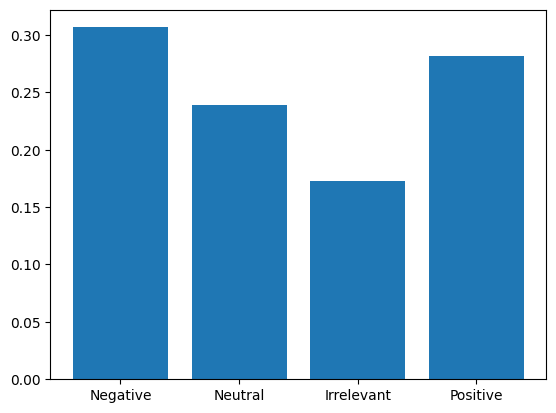

In [7]:
sentiments=list(df["Sentiment"].unique())
sentiment_nums=[len(df[df["Sentiment"]==sentiments])/len(df) for sentiments in sentiments]

plt.bar(sentiments,sentiment_nums)

one-HOt enCoding

In [8]:
print(df["Entity"].unique())

['Borderlands' 'TomClancysGhostRecon' 'Dota2' 'Fortnite' 'Battlefield'
 'Hearthstone' 'Amazon' 'Google' 'Overwatch' 'Nvidia' 'FIFA'
 'AssassinsCreed' 'Verizon' 'CallOfDuty' 'Cyberpunk2077' 'Xbox(Xseries)'
 'CS-GO' 'WorldOfCraft' 'Microsoft' 'CallOfDutyBlackopsColdWar'
 'MaddenNFL' 'HomeDepot' 'ApexLegends' 'TomClancysRainbowSix'
 'PlayerUnknownsBattlegrounds(PUBG)' 'LeagueOfLegends' 'Facebook'
 'GrandTheftAuto(GTA)' 'NBA2K' 'RedDeadRedemption(RDR)' 'johnson&johnson'
 'PlayStation5(PS5)']


In [9]:
one_hot=pd.get_dummies(df["Entity"], prefix="Entity")

df= df.join(one_hot)

df.head()


,Tweet_ID,Entity,Sentiment,Tweet_Content,Entity_Amazon,Entity_ApexLegends,Entity_AssassinsCreed,Entity_Battlefield,Entity_Borderlands,Entity_CS-GO,...,Entity_Overwatch,Entity_PlayStation5(PS5),Entity_PlayerUnknownsBattlegrounds(PUBG),Entity_RedDeadRedemption(RDR),Entity_TomClancysGhostRecon,Entity_TomClancysRainbowSix,Entity_Verizon,Entity_WorldOfCraft,Entity_Xbox(Xseries),Entity_johnson&johnson
0,2535,Borderlands,Negative,@ Borderlands. Can we get a big fix please? I'...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,11073,TomClancysGhostRecon,Negative,@GhostRecon You call 1.1.0 an update. You're h...,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3024,Dota2,Neutral,I'm excited to watch the EU's closed qualifyin...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6719,Fortnite,Negative,"anyways but my fortnite here,, im annoyed.",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1533,Battlefield,Negative,Collateral with the revolver is so satisfying....,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df=df.drop("Entity",axis=1)

TEXTBLOB


In [11]:
from textblob import TextBlob

def tb_enrich(ls):
    tb_polarity = []
    tb_subject = []

    for tweet in ls:
        sentiment = TextBlob(tweet).sentiment
        tb_polarity.append(sentiment[0])
        tb_subject.append(sentiment[1])

    return tb_polarity, tb_subject

# Assuming you have imported the necessary libraries and have a DataFrame 'df'
df['Polarity'], df['Subjective'] = tb_enrich(list(df["Tweet_Content"]))



df.head()


,Tweet_ID,Sentiment,Tweet_Content,Entity_Amazon,Entity_ApexLegends,Entity_AssassinsCreed,Entity_Battlefield,Entity_Borderlands,Entity_CS-GO,Entity_CallOfDuty,...,Entity_PlayerUnknownsBattlegrounds(PUBG),Entity_RedDeadRedemption(RDR),Entity_TomClancysGhostRecon,Entity_TomClancysRainbowSix,Entity_Verizon,Entity_WorldOfCraft,Entity_Xbox(Xseries),Entity_johnson&johnson,Polarity,Subjective
0,2535,Negative,@ Borderlands. Can we get a big fix please? I'...,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0.0000,0.3625
1,11073,Negative,@GhostRecon You call 1.1.0 an update. You're h...,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.5375,0.4750
2,3024,Neutral,I'm excited to watch the EU's closed qualifyin...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.1375,0.4250
3,6719,Negative,"anyways but my fortnite here,, im annoyed.",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.4000,0.8000
4,1533,Negative,Collateral with the revolver is so satisfying....,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0.0000,0.0000


Label of indexes

In [12]:
class_to_index ={'Neutral':0,'Irrelevant':1,'Negative':2,'Positive':3}

index_to_class = {v: k for k, v in class_to_index.items()}

names_to_ids= lambda n: np.array([class_to_index.get(x)for x in n])
ids_to_names=lambda n:np.array([index_to_class.get(x)for x in n])

In [13]:
print(names_to_ids(["Positive","Negative","Irrelevant","Neutral"]))
print(ids_to_names([0,1,2,3]))

[3 2 1 0]
['Neutral' 'Irrelevant' 'Negative' 'Positive']


In [14]:
df['Sentiment']=names_to_ids(df['Sentiment'])

In [15]:
df.head()

,Tweet_ID,Sentiment,Tweet_Content,Entity_Amazon,Entity_ApexLegends,Entity_AssassinsCreed,Entity_Battlefield,Entity_Borderlands,Entity_CS-GO,Entity_CallOfDuty,...,Entity_PlayerUnknownsBattlegrounds(PUBG),Entity_RedDeadRedemption(RDR),Entity_TomClancysGhostRecon,Entity_TomClancysRainbowSix,Entity_Verizon,Entity_WorldOfCraft,Entity_Xbox(Xseries),Entity_johnson&johnson,Polarity,Subjective
0,2535,2,@ Borderlands. Can we get a big fix please? I'...,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0.0000,0.3625
1,11073,2,@GhostRecon You call 1.1.0 an update. You're h...,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.5375,0.4750
2,3024,0,I'm excited to watch the EU's closed qualifyin...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.1375,0.4250
3,6719,2,"anyways but my fortnite here,, im annoyed.",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.4000,0.8000
4,1533,2,Collateral with the revolver is so satisfying....,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0.0000,0.0000


Data Enrichment

1)dealing with Stop Words


In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Ensure that NLTK resources are downloaded (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define the remove_stopwords function
def remove_stopwords(ls):
    ls = [lemmatizer.lemmatize(word) for word in ls if word not in stop_english and word.isalpha()]
    ls = " ".join(ls)
    return ls

# Assuming you have a DataFrame df with a "Tweet_Content" column
df['Tweet_Content_split'] = df["Tweet_Content"].apply(word_tokenize)

lemmatizer = WordNetLemmatizer()
stop_english = set(stopwords.words("english"))

df["Tweet_Content_Split"] = df["Tweet_Content_split"].apply(remove_stopwords)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [17]:
df.head()

,Tweet_ID,Sentiment,Tweet_Content,Entity_Amazon,Entity_ApexLegends,Entity_AssassinsCreed,Entity_Battlefield,Entity_Borderlands,Entity_CS-GO,Entity_CallOfDuty,...,Entity_TomClancysGhostRecon,Entity_TomClancysRainbowSix,Entity_Verizon,Entity_WorldOfCraft,Entity_Xbox(Xseries),Entity_johnson&johnson,Polarity,Subjective,Tweet_Content_split,Tweet_Content_Split
0,2535,2,@ Borderlands. Can we get a big fix please? I'...,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0.0000,0.3625,"[@, Borderlands, ., Can, we, get, a, big, fix,...",Borderlands Can get big fix please I reset ent...
1,11073,2,@GhostRecon You call 1.1.0 an update. You're h...,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0.5375,0.4750,"[@, GhostRecon, You, call, 1.1.0, an, update, ...",GhostRecon You call update You laugh ca stay c...
2,3024,0,I'm excited to watch the EU's closed qualifyin...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.1375,0.4250,"[I, 'm, excited, to, watch, the, EU, 's, close...",I excited watch EU closed qualifying match EU ...
3,6719,2,"anyways but my fortnite here,, im annoyed.",0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.4000,0.8000,"[anyways, but, my, fortnite, here, ,, ,, im, a...",anyways fortnite im annoyed
4,1533,2,Collateral with the revolver is so satisfying....,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0.0000,0.0000,"[Collateral, with, the, revolver, is, so, sati...",Collateral revolver unk


**Toknisation**

In [34]:
tokenizer = Tokenizer(num_words=10000, lower=True)
tokenizer.fit_on_texts(df['Tweet_Content_Split'])


In [35]:
tweet_tokens = tokenizer.texts_to_matrix(list(df['Tweet_Content_Split']))

In [36]:
tweet_tokens.shape

(7400, 10000)

In [37]:
full_df=pd.concat([df,pd.DataFrame(tweet_tokens)],sort=False,axis=1)
full_df.shape

(7400, 10039)

DROPPING UNUSED DATA & Test -Train Split





In [43]:
y = df["Sentiment"]
X = tweet_tokens

In [44]:
full_df.shape

(7400, 10035)

In [45]:
x_train, x_test, y_train, y_test = train_test_split(full_df, y, test_size=0.2, random_state=1)



In [60]:
model = keras.Sequential([
    keras.layers.Input(shape=(10,)),  # Input layer with 10 features
    keras.layers.Dense(128, activation='relu'),  # Hidden layer with ReLU activation
    keras.layers.Dropout(0.2),  # Dropout layer to prevent overfitting
    keras.layers.Dense(64, activation='relu'),  # Hidden layer with ReLU activation
    keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model with a different learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with more epochs
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)



Epoch 1/20
20/20 [==============================] - 1s 12ms/step - loss: 0.6938 - accuracy: 0.4984 - val_loss: 0.6894 - val_accuracy: 0.5500
Epoch 2/20
20/20 [==============================] - 0s 4ms/step - loss: 0.6905 - accuracy: 0.5469 - val_loss: 0.6901 - val_accuracy: 0.5375
Epoch 3/20
20/20 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5234 - val_loss: 0.6883 - val_accuracy: 0.5688
Epoch 4/20
20/20 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.5297 - val_loss: 0.6889 - val_accuracy: 0.5625
Epoch 5/20
20/20 [==============================] - 0s 3ms/step - loss: 0.6922 - accuracy: 0.5219 - val_loss: 0.6915 - val_accuracy: 0.5625
Epoch 6/20
20/20 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5375 - val_loss: 0.6886 - val_accuracy: 0.5750
Epoch 7/20
20/20 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5172 - val_loss: 0.6952 - val_accuracy: 0.4688
Epoch 8/20
20/20 [=

Model Evaluation

In [59]:
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Convert probabilities to binary predictions
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.2f}")

7/7 [==============================] - 0s 3ms/step
Test Accuracy: 0.56
